# シミュレーテッドアニーリングとベイズ線形回帰によるベイズ最適化

## 文献情報

- タイトル: Bayesian Optimization of Combinatorial Structures
- 著者: R. Baptista and M. Poloczek
- 書誌情報: https://proceedings.mlr.press/v80/baptista18a.html

## 概要

本記事では、目的関数 $f: \mathcal X \to \mathbb R$ を最小化する入力 $x^\ast \in \mathcal X$ を見つける問題のうち、目的関数の内部構造が不明で、目的関数の値の計算に時間が生じるような問題を解くことを想定します。

$$
\begin{aligned}
    & \mathop{\rm minimize}\limits_{x \in \mathcal X} && f(x) \\
    & \mathop{\rm where}
    &&  \text{$f$ の内部構造は不明,} \\
    &&& \text{$f(x)$ の評価に時間がかかる}
\end{aligned}
$$

目的関数の計算に時間がかかるという性質上、焼きなまし法 (SA, simulated annealing) のように、目的関数の評価を何度も実行するメタヒューリスティクス手法の適用は実用的ではありません。そこで使用されるのがモデルベース最適化 (model-based optimization) です。モデルベース最適化では目的関数の入出力関係を近似する “代理モデル” (surrogate model) と呼ばれる回帰モデル $\hat f$ を導入し、以下のようなステップを実行します。

1. 代理モデル $\hat f$ を既知のデータセット $\mathcal D^{(t-1)}$ を用いて更新する
2. 獲得関数 $\alpha: \mathcal X \to \mathbb R$ を代理モデル $\hat f$ を用いて生成する
3. 評価する点 $x^{(t)}$ を獲得関数を最小化することで得る: $x^{(t)} \gets \mathop{\rm arg~min}_{x \in \mathcal X} \alpha(x)$
4. 目的関数の値 $y^{(t)} = f(x^{(t)})$ を得る
5. データセットに新しいデータを追加する: $\mathcal D^{(t)} \gets \mathcal D \cup \{(x^{(t)}, y^{(t)})\}$
6. ステップ $t$ をインクリメント
7. 1.-6.を終了条件に達するまで繰り返す

本記事では、組合せ最適化問題に対するモデルベース最適化の一手法である、**焼きなまし法を用いた Bayesian optimization of combinatorial structures**、通称 `BOCS-SA` を実装していきます。

なお、今回の実装については論文著者等による実装コード https://github.com/baptistar/BOCS/blob/master/BOCSpy/LinReg.py も一部参考にしていますが、具体的な当該コードを本記事に流用することなどは一切行っていないため、本記事のコードは論文著者等のコードに由来するGPLライセンスには該当しません。

## 環境設定

### ライブラリのインストール

In [ ]:
!pip install dwave-neal

### ライブラリのインポート

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import neal
from typing import Optional, Callable
import logging

### ロガーの作成

最適化の進捗を表示するために `logger` を使用します。

In [3]:
def create_logger(name, level=logging.DEBUG):
    logger = logging.getLogger(name)

    # remove existing logger
    for handler in logger.handlers:
        if isinstance(handler, logging.StreamHandler):
            logger.removeHandler(handler)

    logger.setLevel(level)
    ch = logging.StreamHandler()
    ch.setLevel(level)
    formatter = logging.Formatter(
        fmt="%(name)s [%(levelname)s] %(message)s"
    )
    ch.setFormatter(formatter)
    logger.addHandler(ch)
    return logger

logger = create_logger("BOCS-SA")

## 代理モデル

BOCSでは、代理モデルとして入力変数間の2次の項までを考慮する多項式回帰モデルを使用します。すなわち

$$
\begin{aligned}
    \hat f(x; b, w) = b + \sum_i w_i x_i + \sum_{i \lt j} w_{ij} x_i x_j.
    &&
    x \in \{0, 1\}^{d}
\end{aligned}
$$

入力 $x$ は各成分が $0$ または $1$ の $d$ 次元ベクトルとします。上記のモデルは各パラメータ $b, w$ について1次式であるため、線形回帰モデル

$$
    \hat f(x; \theta) = z^\top \theta
$$

に書き直すことができます。したがってベイズ線形回帰の方法でパラメータ $\theta$ のベイズ推定を行うことができます。ただし

$$
\begin{aligned}
z &= [1, x_ix_j]_{i \le j} && \in \mathbb R^{p}, \\
\theta  &= [b, w_{ij}]_{i \le j} && \in \mathbb R^{p}, \\
w_{ii}  &= w_i.
\end{aligned}
$$

理論上は3次以上の項まで考慮することで表現力を向上させることも可能ですが、実用的ではありません。パラメータの個数 $p$ が代理モデルの次数に対し指数オーダーで増加するので、モデルの学習に必要なサンプル点 $(x,y)$ の個数 $N_{\rm req} = |\mathcal D|$ も同様に指数関数的に増加し、さらに学習コストも爆発的に増大してしまうからです。言い換えれば、**表現力とコストはトレードオフの関係にある**と言えます。元論文では2次までの項を考慮するのが最もバランスがよいと主張しているため、ここでもそれに従います。

パラメータの個数 $p$ は、変数 $x$ の次元 $d$ を用いて

$$
p = 1 + d + \binom{d}{2} = 1 + d + \frac{1}{2} d (d-1)
$$

により与えられます。

以上、$p, z$ を作成する関数を準備します。

In [4]:
def calc_p_from_d(d: int) -> int:
    p = 1 + d + d * (d - 1) // 2
    return p

def calc_z_from_x(x: np.ndarray) -> np.ndarray:
    d = len(x)
    p = calc_p_from_d(d)

    z = np.zeros(p, dtype=int)

    # bias
    z[0] = 1

    # linear
    z[1:d+1] = x

    # quadratic
    i,j = np.triu_indices(d, k=1)
    z[d+1:] = x[i] * x[j]
    return z

In [5]:
# TEST

x = np.random.choice([0, 1], 10)
z = calc_z_from_x(x)
print("z:\n", z)

print("-"*10)

x_data = np.random.choice([0, 1], (5,10))
z_data = np.apply_along_axis(calc_z_from_x, 1, x_data)
print("z_data:\n", z_data)

z:
 [1 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0]
----------
z_data:
 [[1 1 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1
  1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0
  0 0 0 0 0 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0]
 [1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0
  1 0 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1]]


以上を代理モデルとしてまとめておきます。

In [6]:
class BOCSSurrogateModel:
    def __init__(self, num_vars, linear_regressor, remove_duplicate: bool = True):
        num_features = calc_p_from_d(num_vars)
        coef = np.zeros(num_features, dtype=np.float64)
        self.params = {
            'coef': coef
        }
        self.linear_regressor = linear_regressor

    def update(self, x_data, y_data):
        z_data = np.apply_along_axis(calc_z_from_x, 1, x_data)
        self.linear_regressor.fit(z_data, y_data)
        self.params['coef'] = self.linear_regressor.coef_

In [7]:
# TEST

num_vars = 16
linear_regressor = None

bocs_surrogate_model = BOCSSurrogateModel(num_vars, linear_regressor)
print(bocs_surrogate_model.params)

{'coef': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])}


## Thompson抽出

BOCSは **Thompson抽出** (Thompson sampling) と呼ばれる手法の1つです。Thompson抽出は代理モデルがパラメータ $\theta$ に特徴づけられる関数 $\hat f(x; \theta)$ の場合によく使用される手法で、

1. パラメータの事後分布 $p(\theta \mid \mathcal D)$ を計算
2. 事後分布に従うサンプル $\tilde \theta \sim p(\theta \mid \mathcal D)$ を1つ引く
3. サンプルを用いた代理モデル $\hat f(x; \tilde \theta)$ を獲得関数 $\alpha(x)$ とする

というステップにより得られる関数 $\alpha(x)$ を獲得関数とします。

$$
\begin{aligned}
    \alpha(x) = \hat f(x; \tilde \theta) \quad
    \text{where} \quad
    \tilde \theta \sim p(\theta \mid \mathcal D)
\end{aligned}
$$

Thompson抽出を実装するには、**事後分布からのサンプリング** を行うアルゴリズムが必要であり、そのために何らかの事前分布を仮定する必要があります。次節でもう少し詳しく説明します。

### ベイズ線形回帰

まず、線形回帰のベイズ的な取り扱い方を説明します。線形回帰は、入力 $x^{(t)} \in \mathbb R^{p}$ と出力 $y^{(t)} \in \mathbb R$ の関係を次のようにモデル化します。

$$
\begin{aligned}
    y^{(t)}
    &= \theta_1 x^{(t)}_1 + \theta_2 x^{(t)}_2 + \dots + \theta_p x^{(t)}_p + \varepsilon^{(t)} \\
    &= x^{(t) \top} \theta + \varepsilon^{(t)}
\end{aligned}
$$

ここで $\theta \in \mathbb R^{p}$ は係数、$\varepsilon^{(t)}$ はノイズです。ノイズには通常、次のような正規分布を仮定します。

$$
\begin{aligned}
    \varepsilon^{(t)} \sim \mathcal N(0, \sigma^2)
\end{aligned}
$$

これは出力 $y^{(t)}$ が平均 $x^{(t)\top} \theta$、分散 $\sigma^2$ の正規分布に従うと仮定していることと等価です。

$$
\begin{aligned}
    y^{(t)} \mid x^{(t)}, \theta, \sigma \sim \mathcal N(x^{(t)\top} \theta, \sigma^2)
\end{aligned}
$$

この $y^{(t)}$ が従う確率分布の確率密度関数は次式で与えられます。

$$
\begin{aligned}
    p(y^{(t)} \mid x^{(t)}, \theta, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( -\frac{1}{2\sigma^2} (y^{(t)} - x^{(t) \top} \theta)^2 \right).
\end{aligned}
$$

いま行いたいことは、係数 $\theta$ と分散 $\sigma^2$ をデータ $\mathcal D = \{(x^{(t)}, y^{(t)})\}_{t=1, \dots, N}$ をもとに推定することです。このことは、ベイズ推定の枠組みでは「係数 $\theta$ と分散 $\sigma^2$ の確率分布 $p(\theta, \sigma \mid X, y)$ を求める」ということになります。ここで次のベイズの定理を用います。

$$
\begin{aligned}
    p(\theta, \sigma \mid X, y)
    &= \frac{p(y \mid X, \theta, \sigma) p(\theta, \sigma)}{p(y \mid X)} \\
    &\propto p(y \mid X, \theta, \sigma) p(\theta, \sigma)
\end{aligned}
$$

ただし $y=\{y^{(1)}, \dots, y^{(N)}\}, X=\{x^{(1)}, \dots, x^{(N)}\}$ としました。この式によれば、事前分布 $p(\theta, \sigma)$ を設定し、これにモデルの確率分布 $p(y^{(t)} \mid x^{(t)}, \theta, \sigma)$ を掛け、更に定数倍して規格化することによって、パラメータの事後分布 $p(\theta, \sigma \mid X, y)$ を求めることができます。

### 馬蹄分布の定式化

BOCSは、説明変数の個数 $p$ が非常に多いという状況の典型例と言えるので、スパース性を仮定した事前分布が有効に働く可能性が高いです。そこでBOCSでは馬蹄分布 (horseshoe prior) と呼ばれる事前分布を用います。馬蹄分布の定式化には [Makalic & Schmidt (2016)] による次のような定式化を用います (馬蹄分布について詳しくは本記事の補足で説明します)。

$$
\begin{aligned}
    y \mid x, \theta, \sigma              &\sim \mathcal N(x^\top \theta, \sigma^2) \\
    \theta_i \mid \lambda_i, \tau, \sigma &\sim \mathcal N(0, \lambda_i^2 \tau^2 \sigma^2)
        & i=1,\dots,p \\
    \lambda_i &\sim \mathcal C^+(0, 1)
        & i=1,\dots,p \\
    \tau      &\sim \mathcal C^+(0, 1) \\
    \sigma^2  &\sim \frac{1}{\sigma^2} d\sigma^2
\end{aligned}
$$

ここで $y \in \mathbb R, x \in \mathbb R^p, \theta \in \mathbb R^p$ です。$\mathcal C^+(0, 1)$ は位置パラメータ $0$、尺度パラメータ $1$ の **半コーシー分布** と呼ばれる分布で、以下のような確率密度関数で表されます。

$$
    p(x) = \frac{2}{\pi} \frac{1}{1 + x^2}
$$

$\sigma^2 \sim \sigma^{-2} d\sigma^2$ は、$\sigma^2$ が

$$
    p(\sigma^2) \propto \frac{1}{\sigma^2}
$$

であるような非正則事前分布 (improper prior) に従うことを意味します。ここで “非正則” とは、確率の公理を満たさない、すなわち

$$
    \int p(\sigma^2) d\sigma^2 \ne 1
$$

であることを意味します。このような分布には、たとえば逆ガンマ分布

$$
    p(\sigma^2 \mid \alpha, \beta)
    =
    \frac{\beta^\alpha}{\Gamma(\alpha)}
    \left( \frac{1}{\sigma^2} \right)^{\alpha + 1}
    \exp \left( -\frac{\beta}{\sigma^2} \right)
$$

において $\alpha, \beta \to 0$ としたものなどがあります。

### Gibbsサンプリングの定式化

事前分布を定義したので、次にベイズの定理に従って事後分布 $p(\theta \mid \mathcal D)$ を計算し、そこから事後分布に従うサンプルを生成するアルゴリズムを作成すればよいのですが、残念ながら馬蹄分布はそのままでは事後分布からのサンプリングが難しい分布となっています。それは、半コーシー分布 $\mathcal C^+(0, 1)$ と正規分布 $\mathcal N(0, \lambda_i^2 \tau^2 \sigma^2)$ はそのままでは相性が悪いという事情に由来します。そこで、[Makalic & Schmidt (2016)] では、まず文献 [Wand+ (2011)] に記載されている定理より導かれる以下の補題を利用して、半コーシー分布を逆ガンマ分布に書き換えます。

---

**補題 [Wand+ (2011)]** $x$ が半コーシー分布 $\mathcal C^+ (x \mid 0, a)$ に従うならば、$x^2$ は2段階の階層的な逆ガンマ分布の混合に従う。

$$
\begin{aligned}
    x^2 \mid a' &\sim \Gamma^{-1} \left( x^2 \,\middle|\, \frac{1}{2}, \frac{1}{a'}  \right), \\
    a'  \mid a  &\sim \Gamma^{-1} \left( a'  \,\middle|\, \frac{1}{2}, \frac{1}{a^2} \right).
\end{aligned}
$$

---

これを用いれば、$\lambda_i \sim \mathcal C^+(0,1)$ という部分は補助変数 $\nu_i$ を導入することで

$$
\begin{aligned}
    \lambda_i^2 \mid \nu_i &\sim \Gamma^{-1} \left( \lambda_i^2 \,\middle|\, \frac{1}{2}, \frac{1}{\nu_i} \right), \\
    \nu_i               &\sim \Gamma^{-1} \left( \nu_i       \,\middle|\, \frac{1}{2}, 1               \right)
\end{aligned}
$$

という階層構造に書き直すことができます。$\tau \sim \mathcal C^+(0,1)$ についても同様の書き換えを施すことができ、最終的に以下のようにすべての分布が正規分布と逆ガンマ分布の形で書かれることになります。

$$
\begin{aligned}
    \theta_i \mid \lambda_i, \tau, \sigma
    &\sim \mathcal{N}(\theta_i \mid 0, \lambda_i^2 \tau^2 \sigma^2)
    & i &= 1, \dots, p,
    \\
    \lambda_i^2 \mid \nu_i
    &\sim \Gamma^{-1} \left( \lambda_i^2 \,\middle|\, \frac{1}{2}, \frac{1}{\nu_i} \right),
    & i &= 1, \dots, p,
    \\
    \tau^2 \mid \xi
    &\sim \Gamma^{-1} \left( \tau^2 \,\middle|\, \frac{1}{2}, \frac{1}{\xi} \right),
    \\
    \nu_i
    &\sim \Gamma^{-1} \left( \nu_i \,\middle|\, \frac{1}{2}, 1 \right),
    & i &= 1, \dots, p,
    \\
    \xi
    &\sim \Gamma^{-1} \left( \xi \,\middle|\, \frac{1}{2}, 1 \right),
    \\
    \sigma^2
    &\sim \frac{1}{\sigma^2} d\sigma^2.
\end{aligned}
$$

逆ガンマ分布は正規分布の分散に関する共役事前分布 (事前分布と事後分布が同じ形となる分布) であり、更に逆ガンマ分布もまた逆ガンマ分布の共役事前分布であるため、この階層構造は都合の良い構造となっています。この階層構造において、各パラメータの条件付き事後分布をベイズの定理を用いて導くと、以下のようになります。

$$
\begin{aligned}
    \theta \mid \mathcal D, \Theta \setminus \{ \theta \}
    &\sim \mathcal{N}(A^{-1} X^\top y, \sigma^2 A^{-1}), 
\\
    \sigma^2 \mid \mathcal D, \Theta \setminus \{ \sigma \}
    &\sim \Gamma^{-1} \left( \frac{p + N}{2}, \frac{ \| y - X \theta \|_2^2 }{2} + \frac{1}{2} \theta^\top \mathop{\rm diag}\left\{ \frac{1}{\lambda_i^2\tau^2} \right\}\theta \right),
\\
    \lambda_i^2 \mid \mathcal D, \Theta \setminus \{ \lambda_i \}
    &\sim \Gamma^{-1} \left( 1, \frac{1}{\nu_i} + \frac{1}{2 \sigma^2} \frac{\theta_i^2}{\tau^2} \right),
    & i &= 1, \dots, p,
\\
    \tau^2 \mid \mathcal D, \Theta \setminus \{ \tau \}
    &\sim \Gamma^{-1} \left( \frac{p + 1}{2}, \frac{1}{\xi} + \frac{1}{2 \sigma^2} \frac{\| \theta \|_2^2}{\| \lambda \|_2^2} \right),
\\
    \nu_i \mid \mathcal D, \Theta \setminus \{ \nu_i \}
    &\sim \Gamma^{-1} \left( 1, 1 + \frac{1}{\lambda_i^2} \right),
    & i &= 1, \dots, p,
\\
    \xi \mid \mathcal D, \Theta \setminus \{ \xi \}
    &\sim \Gamma^{-1} \left( 1, 1 + \frac{1}{\tau^2} \right),
\end{aligned}
$$

ただし

$$
\begin{aligned}
  X &=
  \begin{bmatrix}
    x^{(1) \top} \\ x^{(2) \top} \\ \vdots \\ x^{(t) \top}
  \end{bmatrix} \in \mathbb R^{t \times p},
  &
  y &=
  \begin{bmatrix}
    y^{(1)} \\ y^{(2)} \\ \vdots \\ y^{(t)}
  \end{bmatrix} \in \mathbb R^{t}
\end{aligned}
$$

であり、

$$
\begin{aligned}
    A &= X^\top X + \mathop{\rm diag}\left\{ \frac{1}{\lambda_i^2\tau^2} \right\}
\end{aligned}
$$

であるとします。$\Theta$ は関与するすべてのパラメータの集合 $\{\theta, \lambda_i, \tau, \sigma, \nu_i, \xi \}$ であり、更に $\mathcal D = \{(x^{(t)}), y^{(t)}\}_{t=1, \dots, N}$ であるとします。

以上導出された各パラメータの条件付き事後分布から1つ1つパラメータをサンプリングしていくGibbsサンプリング (Gibbs sampler) と呼ばれる方法により、事後分布に従うサンプルを生成することが可能です。

In [8]:
def sample_from_inv_gamma(shape, scale):
    return 1.0 / np.random.gamma(shape, 1.0 / scale)

def sample_theta(X, y, lamb2, tau2, sigma2):
    Phi = X / np.sqrt(sigma2)
    alpha = y / np.sqrt(sigma2)
    delta = tau2 * lamb2 * sigma2

    N, p = Phi.shape
    u = np.random.normal(0, np.sqrt(delta), p)
    d = np.random.normal(0, 1, N)
    v = Phi @ u + d
    w = np.linalg.solve((delta * Phi) @ Phi.T + np.eye(N), alpha - v)
    theta_new = u + (delta * Phi).T @ w

    return theta_new

def sample_sigma2(X, y, theta, lamb2, tau2):
    N, p = X.shape
    shape = (N + p) / 2
    scale = np.sum((y - X @ theta)**2) / 2 + np.sum(theta**2 / lamb2 / tau2) / 2
    sigma2_new = sample_from_inv_gamma(shape, scale)
    return sigma2_new

def sample_lamb2(theta, sigma2, tau2, nu):
    shape = 1.0
    scale = 1.0 / nu + theta**2 / sigma2 / tau2 / 2
    lamb2_new = sample_from_inv_gamma(shape, scale)
    return lamb2_new

def sample_tau2(theta, sigma2, lamb2, xi):
    p = len(theta)
    shape = (p + 1) / 2
    scale = 1.0 / xi + np.sum(theta**2 / sigma2 / lamb2) / 2
    tau2_new = sample_from_inv_gamma(shape, scale)
    return tau2_new

def sample_nu(lamb2):
    shape = 1.0
    scale = 1.0 + 1.0 / lamb2
    nu_new = sample_from_inv_gamma(shape, scale)
    return nu_new

def sample_xi(tau2):
    shape = 1.0
    scale = 1.0 + 1.0 / tau2
    xi_new = sample_from_inv_gamma(shape, scale)
    return xi_new

こうして作成された各サンプリングの関数をまとめてループさせます。

In [9]:
def horseshoe_gibbs_sampling(X, y, theta, sigma2, lamb2, tau2, nu, xi, max_iter, logger=None):
    for i in range(max_iter):
        xi = sample_xi(tau2)
        nu = sample_nu(lamb2)
        tau2 = sample_tau2(theta, sigma2, lamb2, xi)
        lamb2 = sample_lamb2(theta, sigma2, tau2, nu)
        sigma2 = sample_sigma2(X, y, theta, lamb2, tau2)
        theta = sample_theta(X, y, lamb2, tau2, sigma2)

        if logger is not None:
            logger.info(f"iter: {i:3d}, theta: {np.mean(theta): 10.3e}, sigma2: {sigma2:10.3e}, lamb2: {np.mean(lamb2):10.3e}, tau2: {tau2:10.3e}, nu: {np.mean(nu):10.3e}, xi: {xi:10.3e}, error: {np.mean((y - X @ theta)**2):10.3e}")

    return theta, sigma2, lamb2, tau2, nu, xi

In [10]:
def remove_duplicates_and_average(X, y, logger=None):
    X = np.array(X, dtype=float)
    y = np.array(y, dtype=float)

    sorted_indices = np.lexsort(X.T)
    X = X[sorted_indices]
    y = y[sorted_indices]

    _, unique_indices, counts = np.unique(X, axis=0, return_index=True, return_counts=True)
    X = X[unique_indices]

    sorted_indices = np.lexsort(X.T)
    X = X[sorted_indices]

    remove_indices = []
    for unique_index, count in zip(unique_indices, counts):
        if count > 1:
            y[unique_index] = np.mean(y[unique_index:unique_index+count])
            remove_indices.extend(range(unique_index+1, unique_index+count))
    y = np.delete(y, remove_indices)

    if logger is not None:
        if len(remove_indices) > 0:
            logger.info(f"Removed {len(remove_indices)} duplicate rows")

    return X, y

def get_nonzero_column_indices(X, logger=None):
    nonzero_column_indices = np.where(np.any(X != 0, axis=0))[0]
    if logger is not None:
        if len(nonzero_column_indices) < X.shape[1]:
            logger.info(f"Removed {X.shape[1] - len(nonzero_column_indices)} zero columns")
    return nonzero_column_indices

class HorseshoeGibbs:
    def __init__(
        self,
        max_iter:int=50,
        warm_start:bool=True
    ):
        self.max_iter = max_iter
        self.warm_start = warm_start

        self.coef_ = None
        self.sigma2_ = None
        self.lamb2_ = None
        self.tau2_ = None
        self.nu_ = None
        self.xi_ = None

    def initialize_params(self, num_features):
        self.coef_ = np.zeros(num_features, dtype=np.float64)
        self.sigma2_ = 1.0
        self.lamb2_ = np.random.uniform(0.0, 1.0, num_features).astype(np.float64)
        self.tau2_ = np.random.uniform(0.0, 1.0)
        self.nu_ = np.ones(num_features, dtype=np.float64)
        self.xi_ = 1.0

    def fit(self,
        X: np.ndarray,
        y: np.ndarray,
        logger:Optional[logging.Logger]=None,
    ):
        if (self.sigma2_ is None) or (self.warm_start is False):
            self.initialize_params(X.shape[1])

        X, y = remove_duplicates_and_average(X, y, logger)
        nonzero_column_indices = get_nonzero_column_indices(X, logger).astype(int)
        X = X[:, nonzero_column_indices]

        coef   = self.coef_[nonzero_column_indices]
        sigma2 = self.sigma2_
        lamb2  = self.lamb2_[nonzero_column_indices]
        tau2   = self.tau2_
        nu     = self.nu_[nonzero_column_indices]
        xi     = self.xi_

        coef, sigma2, lamb2, tau2, nu, xi = horseshoe_gibbs_sampling(X, y, coef, sigma2, lamb2, tau2, nu, xi, self.max_iter, logger)

        self.coef_[nonzero_column_indices]  = np.array(coef)
        self.sigma2_                        = sigma2
        self.lamb2_[nonzero_column_indices] = np.array(lamb2)
        self.tau2_                          = tau2
        self.nu_[nonzero_column_indices]    = np.array(nu)
        self.xi_                            = xi


ここで、重複した行を削除する関数として `remove_duplicates_and_average()` 関数を新たに定義し、更にすべての値が `0` であるような列を削除するために `get_nonzero_column_indices()` 関数を定義しています。こうすることで、線形代数計算上のエラーや計算速度の低下を防ぐことができます。

In [11]:
# TEST

logger_horseshoe = create_logger("HS_DEBUG", level=logging.DEBUG)

num_features = 10
num_samples  = 150

coef_true = np.random.normal(0, 10, size=num_features)
x_data = np.random.choice([0, 1], size=(num_samples, num_features))
y_data = x_data @ coef_true + np.random.normal(0, .1, size=num_samples)

horseshoe = HorseshoeGibbs(max_iter=20)
horseshoe.fit(x_data, y_data, logger_horseshoe)

coef_estim = horseshoe.coef_

print("coef_true:\n", coef_true)
print("coef_estim:\n", coef_estim)
print("MSE:\n", np.mean((coef_true - coef_estim)**2))

HS_DEBUG [INFO] Removed 10 duplicate rows
HS_DEBUG [INFO] iter:   0, theta: -1.347e-01, sigma2:  1.846e+02, lamb2:  3.636e+01, tau2:  1.413e-02, nu:  3.219e+01, xi:  9.412e+00, error:  1.048e+02
HS_DEBUG [INFO] iter:   1, theta: -7.155e-02, sigma2:  9.308e+01, lamb2:  5.524e+00, tau2:  1.699e-02, nu:  6.754e+00, xi:  6.228e+02, error:  8.451e+01
HS_DEBUG [INFO] iter:   2, theta:  4.337e-01, sigma2:  7.256e+01, lamb2:  2.400e+00, tau2:  6.108e-02, nu:  4.898e+01, xi:  4.005e+01, error:  2.444e+01
HS_DEBUG [INFO] iter:   3, theta:  4.158e-01, sigma2:  2.810e+01, lamb2:  2.636e+00, tau2:  7.261e-01, nu:  1.009e+01, xi:  7.539e+01, error:  1.115e+01
HS_DEBUG [INFO] iter:   4, theta:  4.421e-01, sigma2:  1.285e+01, lamb2:  5.294e-01, tau2:  7.280e+00, nu:  1.432e+01, xi:  8.084e-01, error:  7.223e-01
HS_DEBUG [INFO] iter:   5, theta:  4.747e-01, sigma2:  7.430e-01, lamb2:  1.165e+00, tau2:  7.506e+01, nu:  1.662e+01, xi:  9.810e-01, error:  6.845e-02
HS_DEBUG [INFO] iter:   6, theta:  4.782

coef_true:
 [  9.23456008   3.30461853  -6.43565479  -5.88720689   5.16053884
 -10.12023364  11.05772715  -6.60391563   9.41823602  -4.4190765 ]
coef_estim:
 [  9.22162225   3.257829    -6.41750444  -5.88901289   5.16060127
 -10.12109919  11.05351743  -6.64992369   9.46811125  -4.37775589]
MSE:
 0.0009019492036717482


### 多変量正規分布からの効率的なサンプリング

上述のGibbsサンプリングにおいてボトルネックとなるのが $\theta \mid \mathcal D, \Theta \setminus \{\theta\}$ のサンプルで、この部分は (1) 逆行列 $A^{-1}$ の計算、(2)多変量正規分布 $\mathcal{N}(A^{-1} X^\top y, \sigma^2 A^{-1})$ からのサンプリング、のいずれも $\mathcal O(p^3) = \mathcal O(d^6)$ もの時間計算量を要求します。この部分を高速化するために、先程のコードでは [Bhattacharya+ (2016)] による以下のアルゴリズムを使用しています。

---

**アルゴリズム [Bhattacharya+ (2016)]**: 以下の多変量正規分布を考える。

$$
\begin{aligned}
    \theta \sim \mathcal N(m, V)
\end{aligned}
$$

ただし

$$
\begin{aligned}
    m &= V \Phi^\top \alpha && \in \mathbb{R}^{p}, \\
    V &= \left( \Phi^\top \Phi + \Delta^{-1} \right)^{-1} && \in \mathbb{R}^{p \times p}
\end{aligned}
$$

であり、$\Phi \in \mathbb R^{N \times p}$、$\alpha \in \mathbb R^N$、$\Delta \in \mathbb R^{p \times p}$、さらに $\Delta$ は正定値行列である。

この分布に従うサンプル $\theta \in \mathbb R^p$ は、以下の方法により生成可能である。

1. $u \in \mathbb R^p$ を多変量正規分布 $\mathcal N(0, \Delta)$ からサンプルする
2. $v \in \mathbb R^N$ を多変量正規分布 $\mathcal N(\Phi u, I)$ からサンプルする
3. 線形方程式 $(\Phi \Delta \Phi^\top + I) w = (\alpha - v)$ を $w$ について解く
4. $\theta = u + \Delta \Phi^\top w$ を計算する

---

アルゴリズムの正当性はSherman–Morrison–Woodburyの公式により示されます。

このアルゴリズムに $\theta \mid \mathcal D, \Theta \setminus \{ \theta \} \sim \mathcal{N}(A^{-1} X^\top y, \sigma^2 A^{-1})$ を当てはめると、

$$
\begin{aligned}
    \Phi = \frac{X}{\sigma}, \quad
    \alpha = \frac{y}{\sigma}, \quad
    \Delta = \mathop{\rm diag} \left\{ \tau_i^2 \lambda^2 \sigma^2 \right\}
\end{aligned}
$$

となります。

以上のアルゴリズムにおいて、最大のボトルネックとなるのは線形方程式を解く部分です。詳細は省略しますが、行列 $\Delta$ がスパースな場合には $\mathcal O(p N^2)$ が、$\Delta$ がスパースでない場合には $\mathcal O(p^2 N)$ が支配的になります。今回の設定ではいずれにせよ $\mathcal O(p^3)$ に比べれば $p$ への依存性が小さくなることが確認できます。

`sample_theta()` 関数では、以上のロジックを用いてサンプリングを高速化するよう工夫しています。

### 獲得関数の最適化

得られたサンプル $\tilde \theta \sim p(\theta | \mathcal D)$ を用いた2次多項式モデル $\alpha(x) = \hat f(x;\tilde\theta)$ を最小化する入力 $x^{(t+1)} = \mathop{\rm arg~min}_x \alpha(x)$ が、次に入力するサンプルとなります。ここからは、この入力を探索するロジックを作成します。

まず2次多項式モデルを最小化する問題 $\mathop{\rm minimize}_x \hat f(x;\tilde\theta)$ が、次式で表されるようなQUBO (quadratic unconstrained binary optimization, 二次無制約二値最適化問題) に書き直すことができる点に注目します。

$$
\begin{aligned}
    \mathop{\rm minimize}\limits_{x \in \{0, 1\}^d} \quad x^\top Q x
\end{aligned}
$$

このことを用いて、今回は $\tilde \theta$ をQUBO行列に変換し、焼きなまし法 (SA) でのサンプリングを行うことで次の入力を探索する方法をとります。

SAによるサンプリングは `dwave-neal` による実装を使用します。

In [12]:
def calc_num_vars_from_num_features(num_features):
    return int((-1 + np.sqrt(8 * num_features - 7)) // 2)

def calc_Q_from_coef(coef):
    num_features = len(coef)
    num_vars = calc_num_vars_from_num_features(num_features)
    Q = np.zeros((num_vars, num_vars))
    i,j = np.diag_indices(num_vars)
    Q[i,j] = coef[1:num_vars+1]
    i,j = np.triu_indices(num_vars, k=1)
    Q[i,j] = coef[num_vars+1:]
    return Q

class BOCSAcquisitionFunction:
    def __init__(self, optimizer: neal.SimulatedAnnealingSampler.sample_qubo):
        self.optimizer = optimizer

    def build(self, surrogate_model):
        coef = surrogate_model.params['coef']
        Q = calc_Q_from_coef(coef)
        self.Q = Q

    def optimize(self):
        response = self.optimizer(self.Q)
        optimal_x = np.array(list(response.first.sample.values()), dtype=int)
        return optimal_x

In [13]:
# TEST 真のQ_trueと推定されたQの類似度を計算

num_vars = 10
num_samples = 250

Q_true = np.triu(np.random.normal(0, 10, size=(num_vars, num_vars)))
x_data = np.random.choice([0, 1], size=(num_samples, num_vars))
y_data = np.einsum("di,dj,ij->d", x_data, x_data, Q_true) + np.random.normal(0, .1, size=num_samples)

horseshoe_linear_regressor = HorseshoeGibbs(max_iter=20)
bocs_surrogate_model = BOCSSurrogateModel(num_vars, linear_regressor=horseshoe_linear_regressor)
bocs_acquis_func = BOCSAcquisitionFunction(neal.SimulatedAnnealingSampler().sample_qubo)

bocs_surrogate_model.update(x_data, y_data)

bocs_acquis_func.build(bocs_surrogate_model)
x_next = bocs_acquis_func.optimize()
y_next = x_next @ Q_true @ x_next

print("x_next:", x_next)
print("y_next:", y_next)
print("similarity:", np.sum( Q_true * bocs_acquis_func.Q) / np.sqrt( np.sum(Q_true**2) * np.sum(bocs_acquis_func.Q**2) ) )

x_next: [0 0 1 1 1 0 1 1 1 1]
y_next: -73.41455419923074
similarity: 0.9991270110292981


## 実験

以上で `BOCS-SA` に必要な機能を準備できたので、いくつかの問題を作成してテストを行いましょう。

### RandomQUBO

まず、簡単な例題として、ランダムに生成されたQUBO形式の目的関数の最適解を探索する問題を取り扱います。

In [14]:
class RandomQUBO:
    def __init__(self, num_vars, noise_variance: float=0., seed: Optional[int]=None):
        self.noise_variance = noise_variance
        self.rng = np.random.default_rng(seed)
        self.Q = self.rng.normal(0, 1, size=(num_vars, num_vars))

    def energy(self, x):
        return x @ self.Q @ x

    def __call__(self, x):
        return self.energy(x) + self.rng.normal(0, np.sqrt(self.noise_variance))

SAによりこのモデルの最小化問題の最適解を探索します。

In [15]:
# TEST

seed = 0
rng  = np.random.default_rng(seed)

num_vars         = 16
num_init_samples = 5
noise_variance   = 0.1

random_qubo = RandomQUBO(num_vars, noise_variance=0.1, seed=seed)
Q = random_qubo.Q

response = neal.SimulatedAnnealingSampler().sample_qubo(Q, num_reads=10)
print(response)

GS_energy = response.first.energy
GS_sample = list(response.first.sample.values())
print("Approximate groudstate:", GS_sample, GS_energy)

   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15     energy num_oc.
0  1  1  0  0  0  0  1  0  0  1  1  1  1  1  1  1 -25.135564       1
1  1  1  0  0  0  0  1  0  0  1  1  1  1  1  1  1 -25.135564       1
2  1  1  0  0  0  0  1  0  0  1  1  1  1  1  1  1 -25.135564       1
3  1  1  0  0  0  0  1  0  0  1  1  1  1  1  1  1 -25.135564       1
4  1  1  0  0  0  0  1  0  0  1  1  1  1  1  1  1 -25.135564       1
5  1  1  0  0  0  0  1  0  0  1  1  1  1  1  1  1 -25.135564       1
6  1  1  0  0  0  0  1  0  0  1  1  1  1  1  1  1 -25.135564       1
7  1  1  0  0  0  0  1  0  0  1  1  1  1  1  1  1 -25.135564       1
8  1  1  0  0  0  0  1  0  0  1  1  1  1  1  1  1 -25.135564       1
9  1  1  0  0  0  0  1  0  0  1  1  1  1  1  1  1 -25.135564       1
['BINARY', 10 rows, 10 samples, 16 variables]
Approximate groudstate: [1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1] -25.135563764520846


以上の目的関数と、代理モデル、獲得関数、ソルバーを指定し、ベイズ最適化を実行します。

In [16]:
surrogate_model = BOCSSurrogateModel(num_vars, linear_regressor=HorseshoeGibbs(max_iter=10))
acquisition_function = BOCSAcquisitionFunction(neal.SimulatedAnnealingSampler().sample_qubo)

X = rng.choice([0, 1], size=(num_init_samples, num_vars))
y = np.array([random_qubo(x) for x in X])

# bayesian optimization loop
y_best = np.inf
for i in range(200):
    surrogate_model.update(X, y)
    acquisition_function.build(surrogate_model)
    x_next = acquisition_function.optimize()
    y_next = random_qubo(x_next) # 関数の “観測値” を記録

    X = np.vstack([X, x_next])
    y = np.hstack([y, y_next])

    y_best = min(y_best, random_qubo.energy(x_next)) # 関数の真の値を記録
    if i % 10 == 0:
        logger.info(
            "iter: {:3d}, y_next: {:10.3e}, y_best: {:10.3e}, GS: {:10.3e}"
            .format(i, y_next, y_best, GS_energy)
        )

BOCS-SA [INFO] iter:   0, y_next:  2.865e+00, y_best:  3.008e+00, GS: -2.514e+01
BOCS-SA [INFO] iter:  10, y_next: -1.345e+01, y_best: -1.378e+01, GS: -2.514e+01
BOCS-SA [INFO] iter:  20, y_next: -2.105e+01, y_best: -2.095e+01, GS: -2.514e+01
BOCS-SA [INFO] iter:  30, y_next: -1.668e+01, y_best: -2.240e+01, GS: -2.514e+01
BOCS-SA [INFO] iter:  40, y_next: -2.452e+01, y_best: -2.472e+01, GS: -2.514e+01
BOCS-SA [INFO] iter:  50, y_next: -2.138e+01, y_best: -2.472e+01, GS: -2.514e+01
BOCS-SA [INFO] iter:  60, y_next: -2.490e+01, y_best: -2.472e+01, GS: -2.514e+01
BOCS-SA [INFO] iter:  70, y_next: -2.520e+01, y_best: -2.472e+01, GS: -2.514e+01
BOCS-SA [INFO] iter:  80, y_next: -1.913e+01, y_best: -2.472e+01, GS: -2.514e+01
BOCS-SA [INFO] iter:  90, y_next: -2.449e+01, y_best: -2.514e+01, GS: -2.514e+01
BOCS-SA [INFO] iter: 100, y_next: -1.013e+01, y_best: -2.514e+01, GS: -2.514e+01
BOCS-SA [INFO] iter: 110, y_next: -2.526e+01, y_best: -2.514e+01, GS: -2.514e+01
BOCS-SA [INFO] iter: 120, y_

得られた結果をプロットしてみましょう。

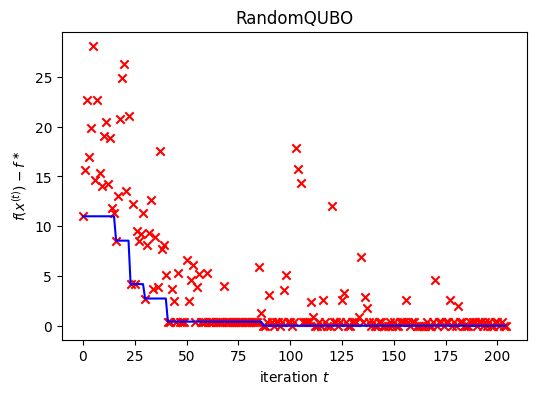

In [17]:
plot_x = X
plot_y = np.apply_along_axis(random_qubo.energy, 1, X)

plot_min_y = np.array([np.min(plot_y[:i]) for i in range(1, len(y)+1)])

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot()

ax.plot(np.arange(len(plot_min_y)), plot_min_y - GS_energy, color="blue")
ax.scatter(np.arange(len(plot_y)), plot_y - GS_energy, color="red", marker="x")

ax.set_title("RandomQUBO")
ax.set_xlabel("iteration $t$")
ax.set_ylabel(r"$f(x^{(t)}) - f^\ast$")

plt.show()

今回は $d=16$ という小規模な設定なので、比較的簡単に最適解を発見することができています。最終的には $t=85$ 程度で最適解に到達しており、BOCSが上手く機能していることがわかります。

### RandomHUBO

3対相互作用を持つ高次元2値最適化も行ってみましょう。目的関数として

$$
  f(x) = \sum_{i,j,k} Q_{ijk} x_i x_j x_k
$$

を仮定してみます。

In [18]:
class RandomHUBO:
    def __init__(self, num_vars, noise_variance: float=0., seed: Optional[int]=None):
        self.noise_variance = noise_variance
        self.rng = np.random.default_rng(seed)
        self.Q = self.rng.normal(0, 1, size=(num_vars, num_vars, num_vars))

    def energy(self, x):
        return np.einsum('ijk,i,j,k', self.Q, x, x, x)

    def __call__(self, x):
        return self.energy(x) + self.rng.normal(0, np.sqrt(self.noise_variance))

In [19]:
seed = 0
rng  = np.random.default_rng(seed)

num_vars         = 16
num_init_samples = 5
noise_variance   = 0.

random_hubo = RandomHUBO(num_vars, noise_variance, seed)
surrogate_model = BOCSSurrogateModel(num_vars, linear_regressor=HorseshoeGibbs(max_iter=10))
acquisition_function = BOCSAcquisitionFunction(
    lambda Q: neal.SimulatedAnnealingSampler().sample_qubo(Q, num_reads=5, num_sweeps=2500)
)

X = rng.choice([0, 1], size=(num_init_samples, num_vars))
y = np.array([random_hubo(x) for x in X])

# bayesian optimization loop
y_best = np.inf
for i in range(200):
    surrogate_model.update(X, y)
    acquisition_function.build(surrogate_model)
    x_next = acquisition_function.optimize()
    y_next = random_hubo(x_next)

    X = np.vstack([X, x_next])
    y = np.hstack([y, y_next])

    y_best = min(y_best, y_next)

    if i % 10 == 0:
        logger.info(
            "iter: {:3d}, y_next: {:10.3e}, y_best: {:10.3e}"
            .format(i, y_next, y_best)
        )

BOCS-SA [INFO] iter:   0, y_next: -7.352e+01, y_best: -7.352e+01
BOCS-SA [INFO] iter:  10, y_next: -6.501e+01, y_best: -9.234e+01
BOCS-SA [INFO] iter:  20, y_next: -1.828e+01, y_best: -1.456e+02
BOCS-SA [INFO] iter:  30, y_next: -1.228e+02, y_best: -1.456e+02
BOCS-SA [INFO] iter:  40, y_next: -6.811e+01, y_best: -1.456e+02
BOCS-SA [INFO] iter:  50, y_next: -1.129e+02, y_best: -1.456e+02
BOCS-SA [INFO] iter:  60, y_next: -1.195e+02, y_best: -1.456e+02
BOCS-SA [INFO] iter:  70, y_next: -1.456e+02, y_best: -1.456e+02
BOCS-SA [INFO] iter:  80, y_next: -1.455e+02, y_best: -1.456e+02
BOCS-SA [INFO] iter:  90, y_next: -1.331e+02, y_best: -1.456e+02
BOCS-SA [INFO] iter: 100, y_next: -9.932e+01, y_best: -1.456e+02
BOCS-SA [INFO] iter: 110, y_next: -1.331e+02, y_best: -1.456e+02
BOCS-SA [INFO] iter: 120, y_next: -9.921e+01, y_best: -1.456e+02
BOCS-SA [INFO] iter: 130, y_next: -1.456e+02, y_best: -1.456e+02
BOCS-SA [INFO] iter: 140, y_next: -1.456e+02, y_best: -1.456e+02
BOCS-SA [INFO] iter: 150,

比較対象としてランダムに探索する方法でも実験してみます。

In [20]:
rng  = np.random.default_rng(seed)

X_rand = rng.choice([0, 1], size=(200+num_init_samples, num_vars))

得られた結果をプロットしてみましょう。

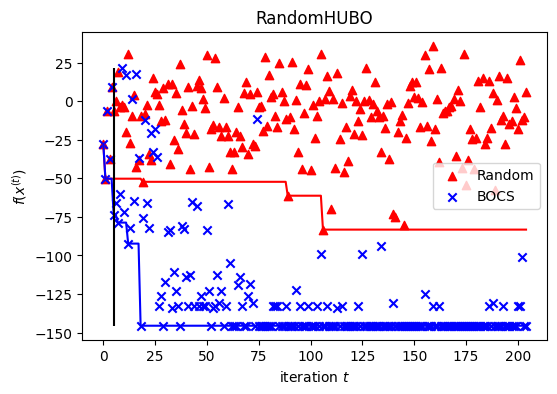

In [21]:
plot_x = X
plot_y = np.apply_along_axis(random_hubo.energy, 1, X)
plot_min_y = np.array([np.min(plot_y[:i]) for i in range(1, len(plot_y)+1)])

plot_X_rand = X_rand
plot_y_rand = np.apply_along_axis(random_hubo.energy, 1, X_rand)
plot_min_y_rand = np.array([np.min(plot_y_rand[:i]) for i in range(1, len(plot_y_rand)+1)])

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot()

ax.plot(np.arange(len(plot_min_y_rand)), plot_min_y_rand, color="red")
ax.scatter(np.arange(len(plot_y_rand)), plot_y_rand, color="red", marker="^", label="Random")

ax.plot(np.arange(len(plot_min_y)), plot_min_y, color="blue")
ax.scatter(np.arange(len(plot_y)), plot_y, color="blue", marker="x", label="BOCS")

ax.vlines(num_init_samples, min(plot_y), max(plot_y), color="black")

ax.set_title("RandomHUBO")
ax.set_xlabel(r"iteration $t$")
ax.set_ylabel(r"$f(x^{(t)})$")
ax.legend()
plt.show()

BOCSでは目的関数値の低い領域を中心にサンプルを集められていることがわかります。

### RandomMLP

更にもう1つ簡単な例として、多層パーセプトロンの最適化を行ってみます。ここでは後の拡張性も考えて、多層パーセプトロンはPyTorchで実装します。

In [22]:
import torch
import torch.nn as nn

class RandomMLP(nn.Module):
    def __init__(self, dim_in, dim_hidden):
        super().__init__()
        self.fc1 = nn.Linear(dim_in, dim_hidden)
        self.fc2 = nn.Linear(dim_hidden, dim_hidden)
        self.fc3 = nn.Linear(dim_hidden, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)

        return x

class RandomMLPWrapper:
    def __init__(self, random_mlp_model: RandomMLP, noise_variance: float=0., seed: Optional[int]=None):
        self.noise_variance = noise_variance
        self.rng = np.random.default_rng(seed)
        self.model = random_mlp_model

    def energy(self, x):
        x = torch.from_numpy(x).float()
        y = self.model(x)
        y = y.detach().numpy().item()
        return y

    def __call__(self, x: np.ndarray):
        return self.energy(x) + self.rng.normal(0, np.sqrt(self.noise_variance))

In [23]:
seed = 0
rng  = np.random.default_rng(seed)

num_vars         = 32
dim_hidden       = 64
num_init_samples = 25
noise_variance   = 0.

random_mlp_model = RandomMLP(num_vars, dim_hidden)
random_mlp = RandomMLPWrapper(random_mlp_model, noise_variance, seed)
surrogate_model = BOCSSurrogateModel(num_vars, linear_regressor=HorseshoeGibbs(max_iter=10))
acquisition_function = BOCSAcquisitionFunction(
    lambda Q: neal.SimulatedAnnealingSampler().sample_qubo(Q, num_reads=5, num_sweeps=2500)
)

X = rng.choice([0, 1], size=(num_init_samples, num_vars))
y = np.array([random_mlp(x) for x in X])

# bayesian optimization loop
y_best = np.inf
for i in range(200):
    surrogate_model.update(X, y)
    acquisition_function.build(surrogate_model)
    x_next = acquisition_function.optimize()
    y_next = random_mlp(x_next)

    X = np.vstack([X, x_next])
    y = np.hstack([y, y_next])

    y_best = min(y_best, y_next)

    if i % 10 == 0:
        logger.info(
            "iter: {:3d}, y_next: {:10.3e}, y_best: {:10.3e}"
            .format(i, y_next, y_best)
        )

BOCS-SA [INFO] iter:   0, y_next: -1.249e-02, y_best: -1.249e-02
BOCS-SA [INFO] iter:  10, y_next: -9.154e-02, y_best: -1.936e-01
BOCS-SA [INFO] iter:  20, y_next: -1.038e-01, y_best: -1.936e-01
BOCS-SA [INFO] iter:  30, y_next: -1.885e-01, y_best: -2.140e-01
BOCS-SA [INFO] iter:  40, y_next: -2.331e-01, y_best: -2.533e-01
BOCS-SA [INFO] iter:  50, y_next: -2.311e-01, y_best: -2.559e-01
BOCS-SA [INFO] iter:  60, y_next: -2.383e-01, y_best: -2.605e-01
BOCS-SA [INFO] iter:  70, y_next: -2.535e-01, y_best: -2.605e-01
BOCS-SA [INFO] iter:  80, y_next: -2.668e-01, y_best: -2.697e-01
BOCS-SA [INFO] iter:  90, y_next: -2.663e-01, y_best: -2.697e-01
BOCS-SA [INFO] iter: 100, y_next: -2.663e-01, y_best: -2.697e-01
BOCS-SA [INFO] iter: 110, y_next: -2.597e-01, y_best: -2.699e-01
BOCS-SA [INFO] iter: 120, y_next: -2.692e-01, y_best: -2.699e-01
BOCS-SA [INFO] iter: 130, y_next: -2.668e-01, y_best: -2.699e-01
BOCS-SA [INFO] iter: 140, y_next: -2.663e-01, y_best: -2.699e-01
BOCS-SA [INFO] iter: 150,

ランダムに探索する方法も実験します。

In [24]:
rng  = np.random.default_rng(seed)

X_rand = rng.choice([0, 1], size=(200+num_init_samples, num_vars))

得られた結果をプロットします。

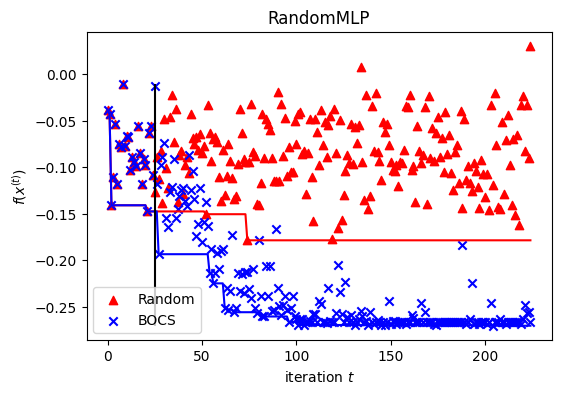

In [25]:
plot_x = X
plot_y = np.apply_along_axis(random_mlp.energy, 1, X)
plot_min_y = np.array([np.min(plot_y[:i]) for i in range(1, len(plot_y)+1)])

plot_X_rand = X_rand
plot_y_rand = np.apply_along_axis(random_mlp.energy, 1, X_rand)
plot_min_y_rand = np.array([np.min(plot_y_rand[:i]) for i in range(1, len(plot_y_rand)+1)])

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot()

ax.plot(np.arange(len(plot_min_y_rand)), plot_min_y_rand, color="red")
ax.scatter(np.arange(len(plot_y_rand)), plot_y_rand, color="red", marker="^", label="Random")

ax.plot(np.arange(len(plot_min_y)), plot_min_y, color="blue")
ax.scatter(np.arange(len(plot_y)), plot_y, color="blue", marker="x", label="BOCS")

ax.vlines(num_init_samples, min(plot_y), max(plot_y), color="black")

ax.set_title("RandomMLP")
ax.set_xlabel(r"iteration $t$")
ax.set_ylabel(r"$f(x^{(t)})$")
ax.legend()
plt.show()

RandomHUBOの場合と同様、目的関数値の低い領域を中心にサンプルを集められていることがわかります。

## 補足: 縮小係数を考慮した事前分布について

この節では、本記事の途中で出てきた馬蹄分布をもう少し詳しく説明します。

### スパース性の仮定

線形回帰において、入力 $x^{(t)} \in \mathbb R^p$ が高次元な場合、つまり説明変数が多い場合は、成分 $x_i^{(t)}$ のうちのほとんどは出力 $y^{(t)}$ に寄与せず、ごく一部の成分が出力値に大きく影響する傾向にあることが知られています。よって、**スパース性** を仮定する、すなわち係数 $\theta \in \mathbb R^p$ のうち **ごく一部の成分が大きく、それ以外は非常に小さい** ような推定をすると、データの個数 $N$ が少ない場合にもある程度うまく $\theta$ を推定できると考えられます。このような知識を上手く取り込むことができる $\theta$ の事前分布として、以下のような形の分布の定式化がよく行われます。

$$
\begin{align}
    \theta_i \mid \lambda_i, \tau, \sigma \sim \mathcal N(0, \lambda_i^2 \tau^2 \sigma^2)
    \quad i = 1, \dots, p
\end{align}
$$

ただし $\lambda \in \mathbb R^p, \tau \in \mathbb R$ です。ここで、$\lambda, \tau, \sigma$ が所与のもとで、ベイズの定理を用いて $\theta$ の事後分布を計算すると

$$
\begin{aligned}
    p(\theta \mid X, y, \lambda, \tau, \sigma)
    &\propto p(y \mid X, \theta, \lambda, \tau, \sigma) p(\theta \mid \lambda, \tau, \sigma) \\
    &= \prod_{t=1}^N p(y^{(t)} \mid x^{(t)}, \theta, \lambda, \tau, \sigma) \times p(\theta \mid \lambda, \tau, \sigma) \\
    &\propto \exp \left( -\frac{1}{2\sigma^2} \sum_{t=1}^N  (y^{(t)} - x^{(t) \top} \theta)^2 \right) \times\exp \left( - \sum_{i=1}^p \frac{1}{2\lambda_i^2\tau^2\sigma^2} \theta_i^2 \right) \\
    &= \exp\left(
        -\frac{1}{2\sigma^2} \left(
            (y - X \theta)^\top (y - X \theta) + \theta^\top \mathop{\rm diag}\left\{ \frac{1}{\lambda_i^2\tau^2} \right\} \theta
        \right)
    \right) \\
    &= \exp\left(
        -\frac{1}{2} \left(
            \theta^\top \frac{X^\top X}{\sigma^2} \theta + \theta^\top \mathop{\rm diag}\left\{ \frac{1}{\lambda_i^2\tau^2\sigma^2} \right\} \theta - 2 \theta^\top \frac{1}{\sigma^2} X^\top y + \mathrm{const.}
        \right)
    \right) \\
    &\propto \exp\left(
        -\frac{1}{2} \left(
            (\theta - m^\ast)^\top V^{\ast ~ -1} (\theta - m^\ast)
        \right)
    \right)
\end{aligned}
$$

となり、事後分布は多変量正規分布となることがわかります。

$$
\begin{aligned}
    \theta \mid \cdot \sim \mathcal N_p(m^\ast, V^\ast)
\end{aligned}
$$

ただし $X = [x_i^{(t)}]_{t,i} \in \mathbb R^{N \times p}$ は観測行列 (入力を並べた行列)、$y = [y^{(t)}]_i \in \mathbb R^{N}$ は応答ベクトル (出力を並べたベクトル) であり、

$$
\begin{alignedat}{3}
    V^{\ast ~ -1}
    &= \frac{1}{\sigma^2} X^\top X + \mathop{\rm diag}\left\{ \frac{1}{\lambda_i^2\tau^2\sigma^2} \right\}
    &&= \frac{1}{\sigma^2} A, \\
    m^\ast
    &= \frac{1}{\sigma^2} V^\ast X^\top y
    &&= A^{-1} X^\top y, \\
    A &= X^\top X + \mathop{\rm diag}\left\{ \frac{1}{\lambda_i^2\tau^2} \right\}
\end{alignedat}
$$

です。

### 縮小係数

さて、ここまでは $y^{(i)} = x^{(i) ~ \top} \theta + \varepsilon$、すなわち

$$
\begin{aligned}
  y^{(1)} &= \sum_i x^{(1)}_i \theta_i + \varepsilon \\
  y^{(2)} &= \sum_i x^{(2)}_i \theta_i + \varepsilon \\
  & \vdots \\
  y^{(N)} &= \sum_i x^{(N)}_i \theta_i + \varepsilon \\
\end{aligned}
$$

という状況を考えてきましたが、ここからはこれに更に条件を追加して、$N=p$ とし、更に $t$ 番目の観測で入力ベクトルの $t$ 番目の要素 $x_t^{(t)}$ のみが $1$、それ以外がすべて $0$ であるような入力 $X=I_p$ を与えたとして、

$$
\begin{aligned}
    y^{(i)} = \theta_i + \varepsilon \quad (t=1,\dots,p)
\end{aligned}
$$

という状況を考えてみます。すると事後平均 $m^{\ast}$ は

$$
\begin{aligned}
m^\ast
&= \left( X^\top X + \mathop{\rm diag}\left\{ \frac{1}{\lambda_i^2\tau^2} \right\} \right)^{-1} X^\top y \\
&= \left( I_p + \mathop{\rm diag}\left\{ \frac{1}{\lambda_i^2\tau^2} \right\} \right)^{-1} y
\end{aligned}
$$

となり、その第 $i$ 成分 $m^\ast_i$ は

$$
\begin{aligned}
m^\ast_i &= \dfrac{1}{1 + \dfrac{1}{\lambda_i^2 \tau^2}} y^{(i)} = \left( 1 - \dfrac{1}{1 + \lambda_i^2 \tau^2} \right) y^{(i)}
\end{aligned}
$$

となります。ここで

$$
\begin{aligned}
    \kappa_i = \frac{1}{1 + \lambda_i^2 \tau^2}
\end{aligned}
$$

とすれば

$$
\begin{aligned}
    m^\ast_i = (1 - \kappa_i) y_i
\end{aligned}
$$

となります。ここで新たに登場した $\kappa_i = \dfrac{1}{1 + \lambda_i^2 \tau^2}$ を縮小係数 (shrinkage coefficient) といいます。今 $0 \lt \lambda_i^2 \tau^2$ なので、縮小係数の取りうる範囲は $0 \lt \kappa_i \lt 1$ となります。当然ながら $0 \lt 1-\kappa_i \lt 1$ です。上の式からわかるように、$\theta$ の事後平均 $m^\ast$ の第 $i$ 成分 $m^\ast_i$ は、$y$ の第 $i$ 成分 $y_i$ を $1 - \kappa_i$ 倍に縮小した格好となっています。すなわち **縮小係数 $\kappa_i$ は観測された値 $y_i$ をどれほど $0$ に圧縮するかに寄与します**。$\kappa_i \approx 0$ の場合には $y_i$ がほとんどそのまま $m^\ast_i$ となる一方、$\kappa_i \approx 1$ の場合には $m^\ast_i \approx 0$ に圧縮します。そして $\kappa_i$ が $1$ に近いか $0$ に近いかは $\lambda_i^2 \tau^2$ の値によります。

以上をまとめると、

- $\lambda_i^2 \tau^2$ が $0$ に近いほど $\kappa_i$ は $1$ に近づき、$m^\ast_i$ は $0$ に圧縮される
- $\lambda_i^2 \tau^2$ が $1$ に近いほど $\kappa_i$ は $0$ に近づき、$m^\ast_i$ は圧縮されない

という特徴があるといえます。更に $\lambda_i^2$ は各 $\kappa_i$ の値に影響し、$\tau^2$ はすべての $\kappa_1, \kappa_2, \dots, \kappa_p$ に影響します。よって

- $\lambda_i$ は各係数の推定値 $m^\ast_i$ が $0$ に圧縮されるかに寄与する
- $\tau$ は係数の推定値全体 $m^\ast$ が $0$ に圧縮されるかに寄与する

といえます。そこで $\lambda_i$ を **局所縮小パラメータ** (local shrinkage parameter)、$\tau$ を **大域縮小パラメータ** (global shrinkage parameter) といいます。

### 馬蹄分布

以上の議論によれば、縮小係数 $\kappa_i$ が推定値 $m_i^\ast$ に強く影響するといえます。そこで気になるのが縮小係数 $\kappa_i$ がどのような分布に従うのか、ということです。縮小係数は $\lambda_i$ と $\tau$ に影響を受けます。ここで簡単のために $\tau=1$ と固定する場合、$p(\kappa_i)$ は $\lambda_i$ の分布 $p(\lambda_i)$ を変数変換することにより得られます。

様々な $p(\lambda_i)$ に対応する $p(\kappa_i)$ の分布の具体的な形状は文献 [Carvalho+ (2009)] にまとめられていますが、特に $\lambda_i \sim \mathcal C^+(0,1)$ と仮定した場合、$\kappa_i$ は次のようなベータ分布 $\mathop{\rm Beta}(0.5, 0.5)$ に従います。

$$
\begin{aligned}
  p(\kappa_i) = \frac{1}{\pi}(1-\kappa_i)^{-\frac{1}{2}}\kappa_i^{-\frac{1}{2}}
\end{aligned}
$$

さて、ベータ分布 $\mathop{\rm Beta}(0.5, 0.5)$ の確率密度関数をプロットすると、以下のように馬の蹄 (ひずめ) のような形状が現れます。

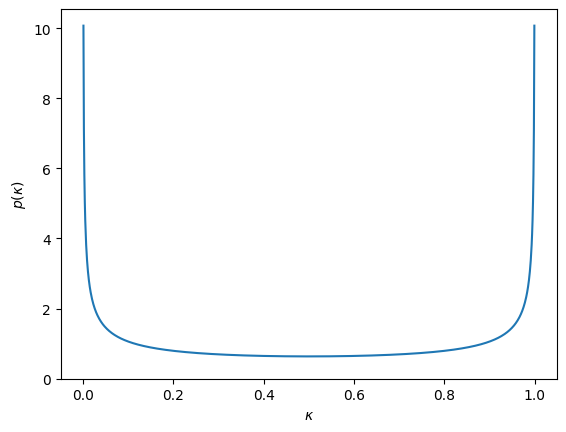

In [26]:
from scipy.special import beta

def _beta_pdf(x, a, b):
    p = 1.0 / beta(a, b) * (1.0 - x)**(-a) * x**(-b)
    return p

x_plot = np.linspace(1e-3, 1.0-1e-3, 1000)
y_plot = _beta_pdf(x_plot, 0.5, 0.5)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(x_plot, y_plot)
ax.set_xlabel(r"$\kappa$")
ax.set_ylabel(r"$p(\kappa)$")
ax.set_ylim(0.0)
plt.show()

このことから、特に $\lambda_i \sim \mathcal C^+(0, 1)$ を仮定する場合、この $\theta$ の事前分布は馬蹄分布 (horseshoe distribution) と呼ばれます。

確率密度関数の形状を見ると明らかなように、馬蹄分布は $\kappa_i \approx 0$ または $\kappa_i \approx 1$ の値を取りやすいという性質を持っています。このような性質から、馬蹄分布を用いることで推定値のうち一部は $0$ に、残りは $0$ に圧縮された推定値を補うような大きな値になることが期待されます。

なお馬蹄分布の由来は縮小係数 $\kappa_i$ がベータ分布 $\mathop{\rm Beta}(0.5,0.5)$ に従うことにありますが、ベータ分布そのものを馬蹄分布と呼ぶのではなく、あくまで $\theta$ の事前分布を馬蹄分布と呼ぶということに注意してください。

## あとがき

本記事ではBOCSの最も基本的な実装を行いました。自分の手で実装することでThompson抽出によるベイズ最適化のフレームワークについて理解することができ、さらに組合せ最適化問題への適用に関する難しさも知ることができました。

またBOCSにおける課題として

- 制約条件付きの問題はどうするのか
- データの数 $N$ や入力次元 $d$ が大きくなると計算コストが大きくなる問題はどうするのか

などの点が気になりました。今後はこのような課題がどのように扱われているのかを調べたり、解決策を探したりして、BOCSの改善策について考えていきたいと思います。

## 参考文献

- [Carvalho+ (2009)] C. M. Carvalho, N. G. Polson, and J. G. Scott, Handling Sparsity via the Horseshoe, in Proceedings of the Twelth International Conference on Artificial Intelligence and Statistics (PMLR, 2009), pp. 73–80.
- [Wand+ (2011)] M. P. Wand, J. T. Ormerod, S. A. Padoan, and R. Frühwirth, Mean Field Variational Bayes for Elaborate Distributions, Bayesian Analysis **6**, 847 (2011).
- [Bhattacharya+ (2016)] A. Bhattacharya, A. Chakraborty, and B. K. Mallick, Fast Sampling with Gaussian Scale Mixture Priors in High-Dimensional Regression, Biometrika **103**, 985 (2016).
- [Makalic & Schmidt (2016)] E. Makalic and D. F. Schmidt, A Simple Sampler for the Horseshoe Estimator, IEEE Signal Processing Letters **23**, 179 (2016).
- [Baptista & Poloczek (2018)] R. Baptista and M. Poloczek, Bayesian Optimization of Combinatorial Structures, in Proceedings of the 35th International Conference on Machine Learning, edited by J. Dy and A. Krause, Vol. 80 (PMLR, 2018), pp. 462–471.

## 本記事の担当者

森田圭祐